In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy import stats
from scipy.fft import fft, fftfreq
from scipy.signal import welch
import warnings

pd.set_option('display.max_columns', None)

# 1. EXPLORACIÓN DEL DATASET

In [19]:
df = pd.read_csv("datos.txt", header=None)
df.columns = ['ID', 'Activity', 'Timestamp', 'X', 'Y', 'Z']
df

,ID,Activity,Timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098204,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098205,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098206,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098207,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098209 entries, 0 to 1098208
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   ID         1098209 non-null  int64  
 1   Activity   1098209 non-null  object 
 2   Timestamp  1098209 non-null  int64  
 3   X          1098209 non-null  float64
 4   Y          1098209 non-null  float64
 5   Z          1098208 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 50.3+ MB


In [21]:
df.describe()

,ID,Timestamp,X,Y,Z
count,1.098209e+06,1.098209e+06,1.098209e+06,1.098209e+06,1.098208e+06
mean,1.886067e+01,3.340892e+13,6.628694e-01,7.255624e+00,4.110784e-01
std,1.021423e+01,4.944961e+13,6.849044e+00,6.746214e+00,4.754120e+00
min,1.000000e+00,0.000000e+00,-1.961000e+01,-1.961000e+01,-1.980000e+01
25%,1.000000e+01,2.019102e+12,-2.870000e+00,3.170000e+00,-2.220000e+00
50%,1.900000e+01,9.722652e+12,2.700000e-01,7.930000e+00,0.000000e+00
75%,2.800000e+01,4.996557e+13,4.440000e+00,1.156000e+01,2.720000e+00
max,3.600000e+01,2.093974e+14,1.995000e+01,2.004000e+01,1.961000e+01


In [22]:
activity_counts = df['Activity'].value_counts()
activity_counts

Activity
Walking       424400
Jogging       342179
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: count, dtype: int64

In [23]:
print(f"\nNúmero de sujetos únicos: {df['ID'].nunique()}")
print(f"Sujetos: {sorted(df['ID'].unique())}")


Número de sujetos únicos: 36
Sujetos: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


`


`

# 2. PREPROCESAMIENTO

`

`

In [24]:
scaler = StandardScaler()
sensor_cols = ['X', 'Y', 'Z']
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])

In [25]:
class_balance = df['Activity'].value_counts(normalize=True) * 100
print(class_balance.round(2))

Activity
Walking       38.64
Jogging       31.16
Upstairs      11.19
Downstairs     9.14
Sitting        5.46
Standing       4.41
Name: proportion, dtype: float64


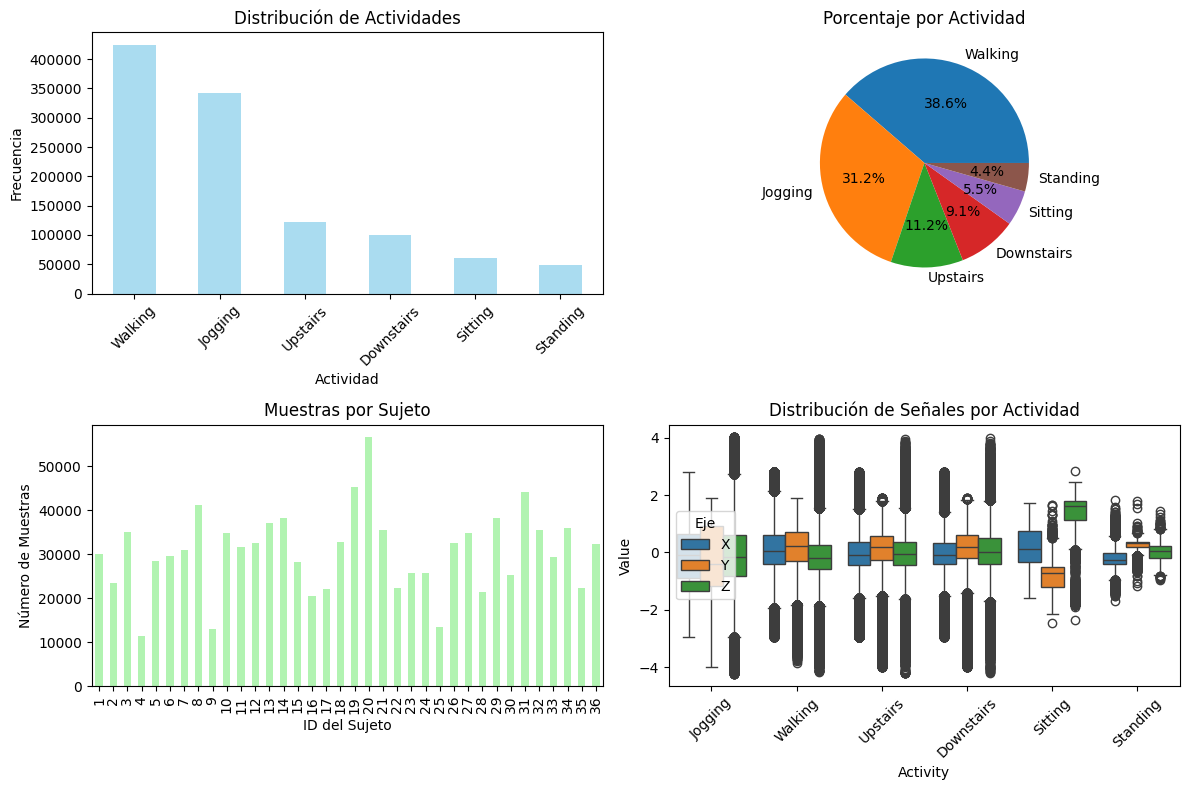

In [26]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
activity_counts.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Distribución de Actividades')
plt.xlabel('Actividad')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
plt.pie(activity_counts.values, labels=activity_counts.index, autopct='%1.1f%%')
plt.title('Porcentaje por Actividad')

plt.subplot(2, 2, 3)
df.groupby('ID')['Activity'].count().plot(kind='bar', color='lightgreen', alpha=0.7)
plt.title('Muestras por Sujeto')
plt.xlabel('ID del Sujeto')
plt.ylabel('Número de Muestras')

plt.subplot(2, 2, 4)
# Boxplot de las señales por actividad
df_melted = df.melt(id_vars=['Activity'], value_vars=['X', 'Y', 'Z'], 
                   var_name='Sensor', value_name='Value')
sns.boxplot(data=df_melted, x='Activity', y='Value', hue='Sensor')
plt.title('Distribución de Señales por Actividad')
plt.xticks(rotation=45)
plt.legend(title='Eje')

plt.tight_layout()
plt.show()


In [27]:
def create_windows(data, window_size=128, overlap=0.5):
    """Crear ventanas temporales con overlap"""
    windows = []
    labels = []
    subjects = []
    
    step = int(window_size * (1 - overlap))
    
    for subject in data['ID'].unique():
        for activity in data['Activity'].unique():
            subject_activity_data = data[(data['ID'] == subject) & 
                                       (data['Activity'] == activity)]
            
            if len(subject_activity_data) >= window_size:
                for i in range(0, len(subject_activity_data) - window_size + 1, step):
                    window = subject_activity_data.iloc[i:i+window_size]
                    windows.append(window[['X', 'Y', 'Z']].values)
                    labels.append(activity)
                    subjects.append(subject)
    
    return np.array(windows), np.array(labels), np.array(subjects)

In [28]:
window_size = 50  # Reducido para el ejemplo
windows, window_labels, window_subjects = create_windows(df, window_size)

print(f"\n✓ Ventanas creadas:")
print(f"  - Tamaño de ventana: {window_size} muestras")
print(f"  - Número de ventanas: {len(windows)}")
print(f"  - Forma de cada ventana: {windows[0].shape}")


✓ Ventanas creadas:
  - Tamaño de ventana: 50 muestras
  - Número de ventanas: 43664
  - Forma de cada ventana: (50, 3)


`

`

# 3. EXTRACCIÓN DE CARACTERÍSTICAS

`

`

In [41]:
def extract_features(windows):
    features = []
    index = 0

    for window in windows:    
        print(f"Window [{index}/43664]")
        window_features = []
        
        for axis in range(3):
            signal = window[:, axis]
            
            window_features.extend([
                np.mean(signal),                # Media
                np.std(signal),                 # Desviación estándar
                np.var(signal),                 # Varianza
                np.min(signal),                 # Mínimo
                np.max(signal),                 # Máximo
                np.median(signal),              # Mediana
                stats.iqr(signal),              # Rango intercuartil
                stats.skew(signal),             # Asimetría
                stats.kurtosis(signal),         # Curtosis
                np.sqrt(np.mean(signal**2)),    # RMS
                np.mean(np.abs(signal)),        # Valor absoluto medio
            ])
            
            # Características frecuenciales (FFT)
            fft_signal = np.abs(fft(signal))
            freqs = fftfreq(len(signal), 1/50)              # 50Hz sampling rate
            
            # Energía espectral
            window_features.extend([
                np.sum(fft_signal**2),                      # Energía total
                np.argmax(fft_signal),                      # Frecuencia dominante (índice)
                np.mean(fft_signal),                        # Media espectral
                np.std(fft_signal),                         # Desviación estándar espectral
            ])
        
        # Características entre ejes
        magnitude = np.sqrt(np.sum(window**2, axis=1))
        window_features.extend([
            np.mean(magnitude),                             # Magnitud media
            np.std(magnitude),                              # Desviación estándar de magnitud
            np.corrcoef(window[:, 0], window[:, 1])[0, 1],  # Correlación X-Y
            np.corrcoef(window[:, 0], window[:, 2])[0, 1],  # Correlación X-Z
            np.corrcoef(window[:, 1], window[:, 2])[0, 1],  # Correlación Y-Z
        ])
        
        features.append(window_features)

        index += 1
    
    return np.array(features)

In [42]:
print("Extrayendo características...")
features = extract_features(windows)

print(f"✓ Características extraídas:")
print(f"  - Número de características por ventana: {features.shape[1]}")
print(f"  - Forma del dataset de características: {features.shape}")

Extrayendo características...
Window [0/43664]
Window [1/43664]
Window [2/43664]
Window [3/43664]
Window [4/43664]
Window [5/43664]
Window [6/43664]
Window [7/43664]
Window [8/43664]
Window [9/43664]
Window [10/43664]
Window [11/43664]
Window [12/43664]
Window [13/43664]
Window [14/43664]
Window [15/43664]
Window [16/43664]
Window [17/43664]
Window [18/43664]
Window [19/43664]
Window [20/43664]
Window [21/43664]
Window [22/43664]
Window [23/43664]
Window [24/43664]
Window [25/43664]
Window [26/43664]
Window [27/43664]
Window [28/43664]
Window [29/43664]
Window [30/43664]
Window [31/43664]
Window [32/43664]
Window [33/43664]
Window [34/43664]
Window [35/43664]
Window [36/43664]
Window [37/43664]
Window [38/43664]
Window [39/43664]
Window [40/43664]
Window [41/43664]
Window [42/43664]
Window [43/43664]
Window [44/43664]
Window [45/43664]
Window [46/43664]
Window [47/43664]
Window [48/43664]
Window [49/43664]
Window [50/43664]
Window [51/43664]
Window [52/43664]
Window [53/43664]
Window [

In [43]:
feature_names = []
axes = ['X', 'Y', 'Z']
stat_names = ['mean', 'std', 'var', 'min', 'max', 'median', 'iqr', 'skew', 'kurtosis', 'rms', 'abs_mean']
freq_names = ['energy', 'dom_freq', 'freq_mean', 'freq_std']

for axis in axes:
    for stat in stat_names:
        feature_names.append(f'{axis}_{stat}')
    for freq in freq_names:
        feature_names.append(f'{axis}_{freq}')

feature_names.extend(['magnitude_mean', 'magnitude_std', 'corr_XY', 'corr_XZ', 'corr_YZ'])

In [44]:
features_df = pd.DataFrame(features, columns=feature_names)
features_df['Activity'] = window_labels
features_df['Subject'] = window_subjects

In [45]:
features_df.head()

,X_mean,X_std,X_var,X_min,X_max,X_median,X_iqr,X_skew,X_kurtosis,X_rms,X_abs_mean,X_energy,X_dom_freq,X_freq_mean,X_freq_std,Y_mean,Y_std,Y_var,Y_min,Y_max,Y_median,Y_iqr,Y_skew,Y_kurtosis,Y_rms,Y_abs_mean,Y_energy,Y_dom_freq,Y_freq_mean,Y_freq_std,Z_mean,Z_std,Z_var,Z_min,Z_max,Z_median,Z_iqr,Z_skew,Z_kurtosis,Z_rms,Z_abs_mean,Z_energy,Z_dom_freq,Z_freq_mean,Z_freq_std,magnitude_mean,magnitude_std,corr_XY,corr_XZ,corr_YZ,Activity,Subject
0,-0.067033,0.628931,0.395554,-1.361564,1.597547,-0.116669,0.834239,-0.014123,-0.043806,0.632493,0.505091,1000.118481,24.0,3.821444,2.323561,0.238390,1.088911,1.185727,-1.921456,1.825738,0.474043,1.792839,-0.131156,-1.148877,1.114700,0.978283,3106.391692,16.0,5.558172,5.588789,0.429912,1.059875,1.123335,-2.229456,2.821465,0.436387,1.161024,-0.330635,0.504377,1.143748,0.886054,3270.398179,0.0,7.158403,3.763672,1.593545,0.641387,-0.100051,-0.085029,0.421287,Jogging,33
1,-0.126334,0.609901,0.371979,-1.361564,1.597547,-0.217096,0.757179,0.457473,0.347697,0.622848,0.498820,969.848115,24.0,3.899242,2.047650,0.145437,1.181831,1.396726,-2.210168,1.825738,0.193407,1.939718,-0.098158,-1.174138,1.190747,1.056006,3544.693705,16.0,6.507843,5.342458,0.466297,0.975596,0.951787,-1.745279,2.821465,0.449279,1.082954,-0.105720,0.122153,1.081305,0.878183,2923.049762,0.0,6.507112,4.014784,1.623025,0.583803,-0.150018,-0.324068,0.431832,Jogging,33
2,-0.143317,0.511996,0.262139,-1.214404,1.273397,-0.264824,0.642831,0.523165,0.104812,0.531676,0.442409,706.698196,23.0,3.182554,2.001328,0.154805,1.213134,1.471695,-2.301021,1.825738,0.446787,1.842303,-0.384758,-0.968482,1.222971,1.083107,3739.147802,15.0,7.110295,4.922059,0.349006,1.014089,1.028377,-1.745279,2.918873,0.413467,1.329340,-0.084192,-0.226101,1.072465,0.881230,2875.455217,0.0,6.744584,3.466942,1.594456,0.621475,-0.128604,-0.165464,0.572522,Jogging,33
3,-0.152067,0.480816,0.231184,-0.852470,1.010895,-0.252892,0.780048,0.416549,-0.820642,0.504290,0.441481,635.770850,23.0,3.024674,1.888589,0.055714,1.180688,1.394025,-2.301021,1.825738,-0.058963,1.628293,-0.170691,-0.890475,1.182002,1.012647,3492.822444,15.0,7.406831,3.872378,0.287982,1.029696,1.060273,-1.891391,2.918873,0.131269,1.068629,0.125183,0.117110,1.069208,0.804361,2858.016894,0.0,6.874096,3.147562,1.506342,0.724968,-0.169132,0.055196,0.532785,Jogging,33
4,-0.228789,0.588729,0.346602,-1.472929,1.698968,-0.322495,0.782037,0.420544,0.877126,0.631622,0.514782,997.366586,0.0,3.841080,2.278911,0.026439,1.253109,1.570282,-2.228339,1.825738,-0.300229,2.027543,0.047349,-1.153768,1.253388,1.089498,3927.451815,16.0,7.487132,4.742562,0.098608,0.995086,0.990196,-2.003125,2.257068,0.078267,1.173917,-0.266962,-0.347676,0.999960,0.780279,2499.798638,4.0,5.866820,3.946694,1.567101,0.716968,-0.307818,0.152804,0.375587,Jogging,33


# 4. MODELADO

In [56]:
features_df = features_df.fillna(0.0)

In [58]:
X = features_df.drop(['Activity', 'Subject'], axis=1)
y = features_df['Activity']

In [59]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [60]:
subjects = features_df['Subject'].values
X_train, X_test, y_train, y_test, subj_train, subj_test = train_test_split(
    X, y_encoded, subjects, test_size=0.3, random_state=42, stratify=y_encoded
)

In [61]:
print(f"✓ División de datos:")
print(f"  - Entrenamiento: {X_train.shape[0]} muestras")
print(f"  - Prueba: {X_test.shape[0]} muestras")
print(f"  - Características: {X_train.shape[1]}")

✓ División de datos:
  - Entrenamiento: 30564 muestras
  - Prueba: 13100 muestras
  - Características: 50


In [62]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=500)
}

### 5-Fold

In [63]:
cv_scores = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    cv_scores[name] = scores
    print(f"  {name}: {scores.mean():.3f} (±{scores.std()*2:.3f})")

  Random Forest: 0.956 (±0.004)
  KNN: 0.814 (±0.006)
  SVM: 0.768 (±0.004)
  MLP: 0.830 (±0.107)


### Training

In [64]:
trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"  ✓ {name} entrenado")

  ✓ Random Forest entrenado
  ✓ KNN entrenado
  ✓ SVM entrenado
  ✓ MLP entrenado


`

`

# 5. EVALUACIÓN

`

`

In [65]:
test_scores = {}
predictions = {}

for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    test_scores[name] = accuracy_score(y_test, y_pred)
    predictions[name] = y_pred
    print(f"{name}: {test_scores[name]:.3f}")

best_model_name = max(test_scores, key=test_scores.get)
best_model = trained_models[best_model_name]
best_predictions = predictions[best_model_name]

print(f"\nMejor modelo: {best_model_name} (Accuracy: {test_scores[best_model_name]:.3f})")

Random Forest: 0.956
KNN: 0.814
SVM: 0.770
MLP: 0.837

Mejor modelo: Random Forest (Accuracy: 0.956)


In [66]:
print(f"\nReporte de clasificación ({best_model_name}):")
print(classification_report(y_test, best_predictions, target_names=le.classes_))


Reporte de clasificación (Random Forest):
              precision    recall  f1-score   support

  Downstairs       0.90      0.82      0.86      1191
     Jogging       0.98      0.99      0.99      4092
     Sitting       1.00      0.98      0.99       709
    Standing       0.99      1.00      0.99       570
    Upstairs       0.90      0.83      0.86      1461
     Walking       0.95      0.98      0.97      5077

    accuracy                           0.96     13100
   macro avg       0.95      0.94      0.94     13100
weighted avg       0.95      0.96      0.95     13100



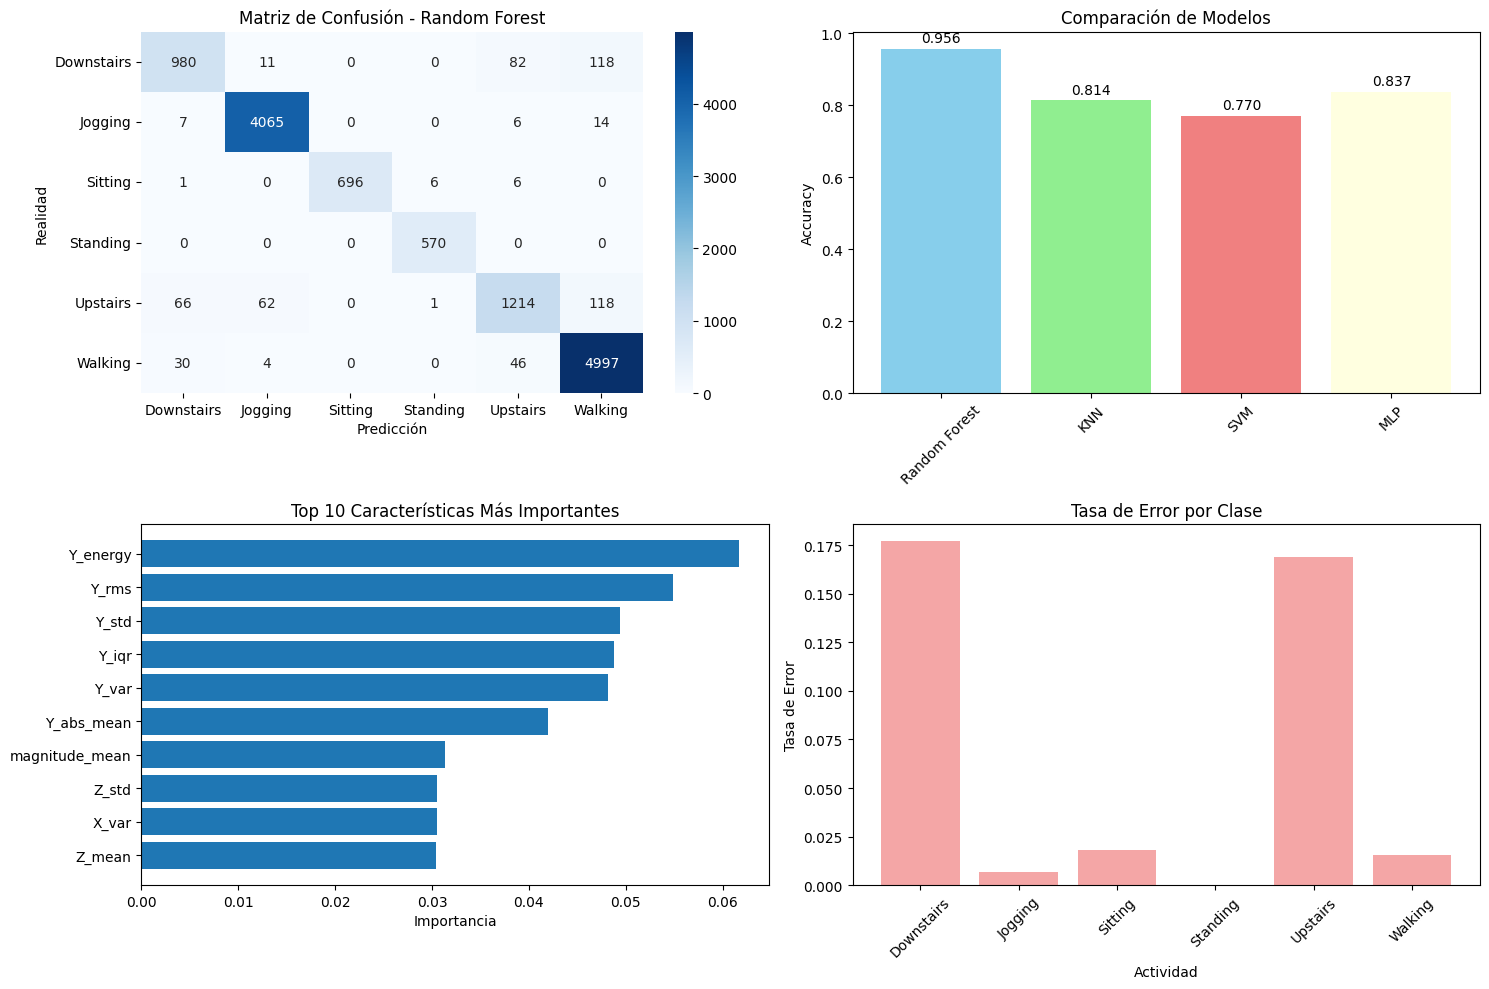

In [72]:
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Matriz de Confusión - {best_model_name}')
plt.xlabel('Predicción')
plt.ylabel('Realidad')

plt.subplot(2, 2, 2)
model_names = list(test_scores.keys())
scores = list(test_scores.values())
bars = plt.bar(model_names, scores, color=['skyblue', 'lightgreen', 'lightcoral', 'lightyellow'])
plt.title('Comparación de Modelos')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Añadir valores en las barras
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom')

# Importancia de características (para Random Forest)
if best_model_name == 'Random Forest':
    plt.subplot(2, 2, 3)
    feature_importance = best_model.feature_importances_
    top_features_idx = np.argsort(feature_importance)[-10:]
    plt.barh(range(len(top_features_idx)), feature_importance[top_features_idx])
    plt.yticks(range(len(top_features_idx)), 
               [feature_names[i] for i in top_features_idx])
    plt.title('Top 10 Características Más Importantes')
    plt.xlabel('Importancia')

# Distribución de errores por clase
plt.subplot(2, 2, 4)
errors_by_class = []
for i, class_name in enumerate(le.classes_):
    mask = y_test == i
    if np.sum(mask) > 0:
        class_accuracy = accuracy_score(y_test[mask], best_predictions[mask])
        errors_by_class.append(1 - class_accuracy)
    else:
        errors_by_class.append(0)

plt.bar(le.classes_, errors_by_class, color='lightcoral', alpha=0.7)
plt.title('Tasa de Error por Clase')
plt.xlabel('Actividad')
plt.ylabel('Tasa de Error')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [73]:
print(f"\nAnálisis de confusiones frecuentes:")
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

confusions = []
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        if i != j and cm_normalized[i, j] > 0.1:  # Más del 10% de confusión
            confusions.append((le.classes_[i], le.classes_[j], cm_normalized[i, j]))

confusions.sort(key=lambda x: x[2], reverse=True)

if confusions:
    print("Confusiones más frecuentes (>10%):")
    for true_class, pred_class, conf_rate in confusions[:5]:
        print(f"  {true_class} → {pred_class}: {conf_rate:.1%}")
else:
    print("No se encontraron confusiones significativas (>10%)")


Análisis de confusiones frecuentes:
No se encontraron confusiones significativas (>10%)


RESUMEN FINAL
📊 Dataset: 1,098,209 muestras, 6 actividades
🪟 Ventanas: 43,664 ventanas de 50 muestras
🔧 Características: 50 características extraídas
🤖 Modelos evaluados: 4
🏆 Mejor modelo: Random Forest
📈 Accuracy final: 0.956
👥 Sujetos en entrenamiento: 36
👥 Sujetos en prueba: 36


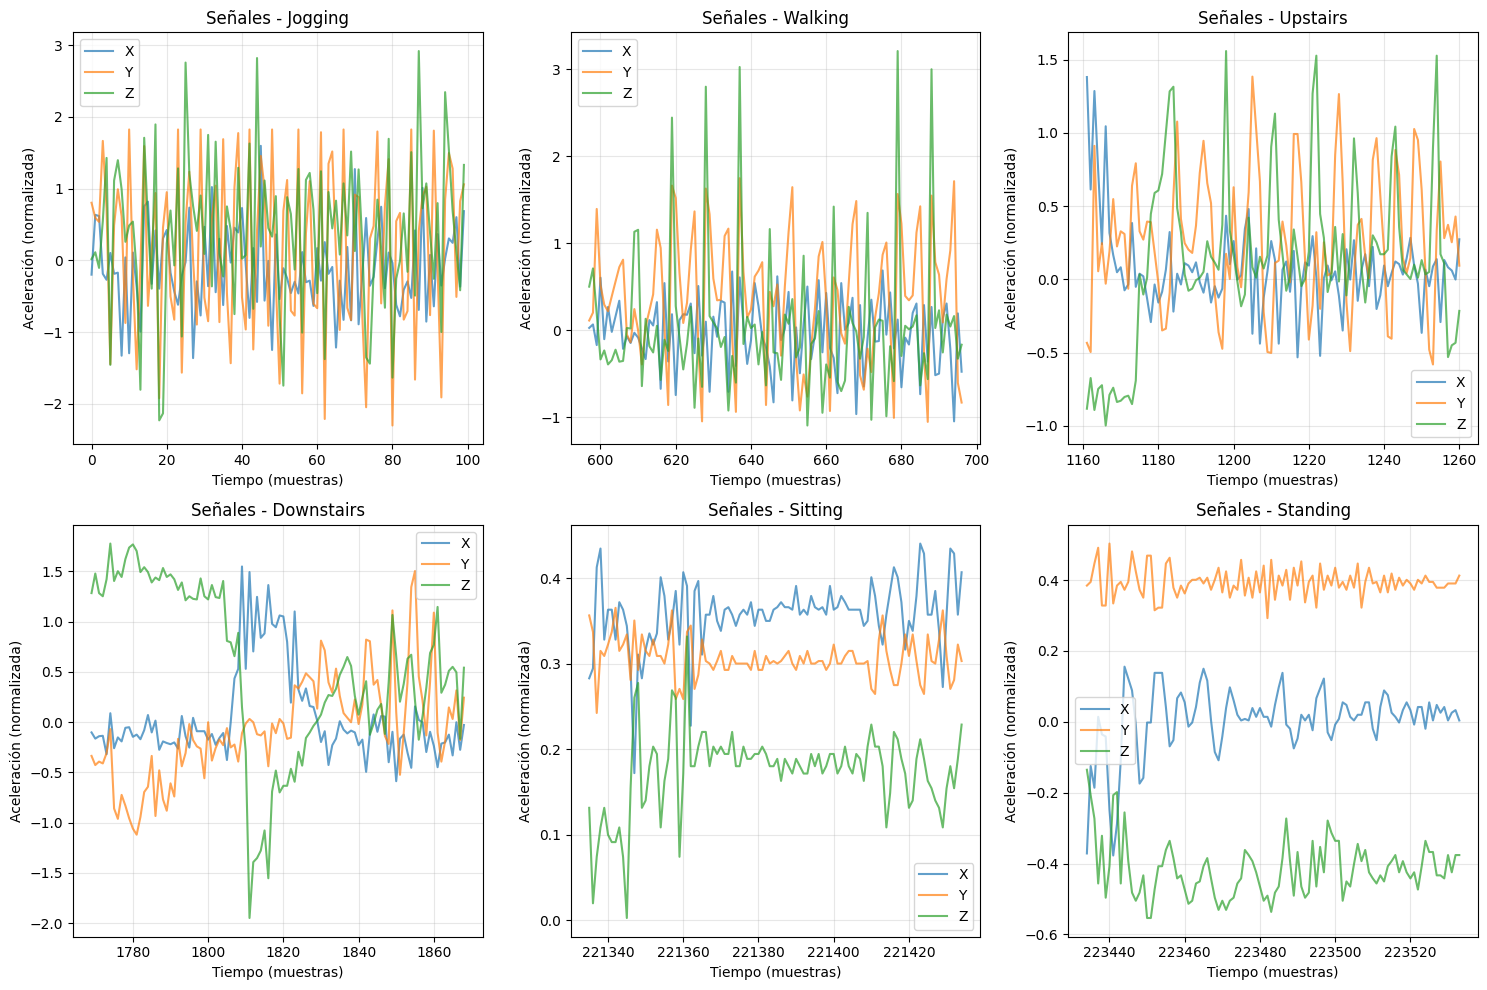


🎯 Proyecto completado exitosamente!
📝 Todas las fases del proyecto han sido implementadas y evaluadas.


In [ ]:
print("RESUMEN FINAL")
print("=" * 60)
print(f"Dataset: {df.shape[0]:,} muestras, {len(df['Activity'].unique())} actividades")
print(f"Ventanas: {len(windows):,} ventanas de {window_size} muestras")
print(f"Características: {features.shape[1]} características extraídas")
print(f"Modelos evaluados: {len(models)}")
print(f"Mejor modelo: {best_model_name}")
print(f"Accuracy final: {test_scores[best_model_name]:.3f}")
print(f"Sujetos en entrenamiento: {len(np.unique(subj_train))}")
print(f"Sujetos en prueba: {len(np.unique(subj_test))}")

# Visualización de señales por actividad
plt.figure(figsize=(15, 10))
activities_sample = df['Activity'].unique()[:6]  # Primeras 6 actividades

for i, activity in enumerate(activities_sample):
    activity_data = df[df['Activity'] == activity].head(100)  # 100 muestras por actividad
    
    plt.subplot(2, 3, i+1)
    plt.plot(activity_data['X'], label='X', alpha=0.7)
    plt.plot(activity_data['Y'], label='Y', alpha=0.7)
    plt.plot(activity_data['Z'], label='Z', alpha=0.7)
    plt.title(f'Señales - {activity}')
    plt.xlabel('Tiempo (muestras)')
    plt.ylabel('Aceleración (normalizada)')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()